In [1]:
import numpy as np
from spectral_cube import SpectralCube
from astropy.io import fits
from reproject import reproject_interp
from tqdm.auto import tqdm
import pyspeckit
from astropy.table import Table, hstack, join
from astropy import stats
import astropy.units as u
import astropy.constants as c

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_cube(cube_filename):
    
    print('[INFO] Loading %s' %cube_filename)
    
    hdu = fits.open(cube_filename)[0]
    hdu.header['BUNIT'] = 'Jy/beam'
    
    cube = SpectralCube.read(hdu)
    cube.allow_huge_operations = True
    cube = cube.to('K')
    cube = cube.with_spectral_unit(u.km/u.s)
    
    return(cube)

def reproject_index_map(cube, index_map_hdu):
        
    # Create 2D header
    header_2d = cube.hdu.header.copy()
    del header_2d['*3*']
    header_2d['NAXIS'] = header_2d['WCSAXES'] = 2 
    index_map_data, _ = reproject_interp(index_map_hdu, header_2d, order='nearest-neighbor')
    
    return(index_map_data)

def get_spec_stats(spec):

    spec_data = np.array(spec)
    spec_axis = np.array(spec.spectral_axis)
    spec_rms = stats.mad_std(spec_data, ignore_nan=True)
    spec_sum = np.nansum(spec_data[spec_data>(spec_rms*5)])
    if spec_sum == 0:
        spec_sum = np.nan
    
    spec_max = np.nanmax(spec_data)
    spec_delta = np.abs(spec_axis[1]-spec_axis[0])
    spec_integratedint = spec_sum*spec_delta
    spec_effwidth = spec_integratedint/(spec_max*np.sqrt(2*np.pi))
    
    return(spec_rms,spec_sum,spec_max,spec_integratedint,spec_effwidth)

def average_spectrum_for_indexes(cube, index_map_hdu):
    
    # Regrid
    print('[INFO] Regridding index map...')
    index_map = reproject_index_map(cube, index_map_hdu)
    index_map[index_map==0] = np.nan
    
    # Load the data cube
    unique_indexes = np.unique(index_map)
    spectra_dict = {}
    spec_id = np.ones(len(unique_indexes)) *np.nan
    spec_rms = np.ones(len(unique_indexes)) *np.nan
    spec_sum = np.ones(len(unique_indexes)) *np.nan
    spec_max = np.ones(len(unique_indexes)) *np.nan
    spec_integratedint = np.ones(len(unique_indexes)) *np.nan
    spec_effwidth = np.ones(len(unique_indexes)) *np.nan
    
    i = 0
    for index in tqdm(unique_indexes):
        
        if i > 20: 
            continue
        
        # Create a mask for the current index
        mask = (index_map == index)

        # If the cube is not loaded in memory, the following approach is more memory efficient
        # masked_cube = cube.with_mask(mask[:, :, np.newaxis])
        masked_cube = cube.with_mask(mask)

        # Calculate the mean spectrum for the masked region
        mean_spectrum = masked_cube.mean(axis=(1, 2))

        spectra_dict[index] = mean_spectrum
        
        spec_stats = get_spec_stats(mean_spectrum)
        spec_id[i] = index
        spec_rms[i] = spec_stats[0]
        spec_sum[i] = spec_stats[1]
        spec_max[i] = spec_stats[2]
        spec_integratedint[i] = spec_stats[3]
        spec_effwidth[i] = spec_stats[4]

        i+=1
        
    return spectra_dict, (spec_id, spec_rms, spec_sum, spec_max, spec_integratedint, spec_effwidth)

def get_virial(velo_disp, radius, mass):
    """Takes velocity dispersion in kms, radius in parsecs, and mass in stellar masses. Returns the virial parameter (unitless)."""
    
    velo_disp_ms = velo_disp.to(u.m/u.s)
    radius_m = radius.to(u.m)
    mass_kg = mass.to(u.kg)
    virial = (5. * velo_disp_ms**2 * radius_m) / (c.G * mass_kg)
    return virial

In [3]:
# Define files 
index_map_filename = "/Users/abarnes/Dropbox/work/scratch/ACES1/data/12m_cont/ACES_leaf_mask_3_1_mp179_pb0.55_pp6_pm2_ar3.0_sm25.fits"
catalog_filename = '/Users/abarnes/Dropbox/work/scratch/ACES1/data/12m_cont/aces_catalog_3_1_mp179_pb0.55_pp6_pm2_ar3.0_sm25.fits'

# cube_hnco_filename = "/Users/abarnes/Dropbox/work/scratch/ACES1/data/12m7mtp_dustridge/Dust_ridge_hnco43.TP_7M_12M_weighted_mosaic.-40_to_90_kms.0.25_kms_resolution.rebin.fits"
cube_hnco_filename = "/Users/abarnes/Dropbox/work/scratch/ACES1/data/12m7mtp_lowres/HNCO_7m12mTP_CubeMosaic_downsampled9_downsampledspectrally.fits"
cube_cs_filename = "/Users/abarnes/Dropbox/work/scratch/ACES1/data/12m_lowres/CS21_CubeMosaic_downsampled9_float32.fits"
cube_hc3n_filename = "/Users/abarnes/Dropbox/work/scratch/ACES1/data/12m_lowres/CS21_CubeMosaic_downsampled9_float32.fits"
cube_sio_filename = "/Users/abarnes/Dropbox/work/scratch/ACES1/data/12m_lowres/SiO21_CubeMosaic_downsampled9_float32.fits"

In [4]:
#Load catalog 
catalog = Table.read(catalog_filename)

In [5]:
#Load cube
cube_hnco = get_cube(cube_hnco_filename)
# cube_cs = get_cube(cube_cs_filename)
# cube_hc3n = get_cube(cube_hc3n_filename)
# cube_sio = get_cube(cube_sio_filename)

#Open index map 
index_map_hdu = fits.open(index_map_filename)[0]

[INFO] Loading /Users/abarnes/Dropbox/work/scratch/ACES1/data/12m7mtp_lowres/HNCO_7m12mTP_CubeMosaic_downsampled9_downsampledspectrally.fits


In [6]:
# Get spectrum 
average_spectra_hnco, spec_stats_hnco = average_spectrum_for_indexes(cube_hnco, index_map_hdu)
# average_spectra_cs, spec_stats_cs = average_spectrum_for_indexes(cube_cs, index_map_hdu)
# average_spectra_hc3n, spec_stats_hc3n = average_spectrum_for_indexes(cube_hc3n, index_map_hdu)
# average_spectra_sio, spec_stats_sio = average_spectrum_for_indexes(cube_sio, index_map_hdu)

[INFO] Regridding index map...


  0%|          | 0/657 [00:00<?, ?it/s]

In [7]:
catalog_spec = Table(spec_stats_hnco, names=['index', 'spec_rms_hnco', 'spec_sum_hnco', 'spec_max_hnco', 'spec_integratedint_hnco', 'spec_effwidth_hnco'])
# catalog_spec = Table(spec_stats_cs, names=['index', 'spec_rms_cs', 'spec_sum_cs', 'spec_max_cs', 'spec_integratedint_cs', 'spec_effwidth_cs'])
# catalog_spec = Table(spec_stats_hc3n, names=['index', 'spec_rms_hc3n', 'spec_sum_hc3n', 'spec_max_hc3n', 'spec_integratedint_hc3n', 'spec_effwidth_hc3n'])
# catalog_spec = Table(spec_stats_sio, names=['index', 'spec_rms_sio', 'spec_sum_sio', 'spec_max_sio', 'spec_integratedint_sio', 'spec_effwidth_sio'])

catalog_all = join(catalog, catalog_spec)

catalog_all['mass'] = catalog_all['mass'] *u.Msun
catalog_all['eff_radius'] = catalog_all['eff_radius'] *u.arcsec
catalog_all['eff_radius_pc'] = catalog_all['eff_radius'] *u.pc/u.arcsec * 0.04
catalog_all['spec_effwidth_hnco'] = catalog_all['spec_effwidth_hnco'] *u.km/u.s

In [8]:
virial = get_virial(catalog_all['spec_effwidth_hnco'], catalog_all['eff_radius_pc'], catalog_all['mass'])
catalog_all.add_column(virial, name='spec_virial_hnco')

In [12]:
catalog_all.write(catalog_filename.replace('.fits', '_spec.fits'), overwrite=True)
catalog_all.write(catalog_filename.replace('.fits', '_spec.csv'), overwrite=True)

In [13]:
catalog_all

index,area_ellipse,area_exact,flux_integrated,major_sigma,minor_sigma,position_angle,radius,RA,Dec,is_leaf,peak_cont_flux,min_cont_flux,mean_cont_flux,npix,noise,axis_ratio,mass,eff_radius,spec_rms_hnco,spec_sum_hnco,spec_max_hnco,spec_integratedint_hnco,spec_effwidth_hnco,eff_radius_pc,spec_virial_hnco
,arcsec2,arcsec2,Jy,arcsec,arcsec,deg,arcsec,,,,,,,,,arcsec,solMass,arcsec,,,,,km / s,pc,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
27.0,3.592655373951185,12.31999999443136,0.0008484039006574256,0.9924588803539179,0.8311991715820239,82.55530816016204,0.9082571217333777,0.772974623023587,-0.2555250521991908,True,0.0007921592636825711,0.0003011137690824358,0.0004938673553116224,308,4.466775689395059e-05,1.1940085051636515,23.493258668286963,1.9802974009001144,0.1556073120558543,11.641776468591809,1.306255123819694,12.118270304829453,3.7010307571409347,0.07921189603600458,53.6909950118094
31.0,3.631037675379646,13.27999999399744,0.001107473757901851,0.941231995184215,0.8858009420535387,178.87715452647478,0.9130959358277253,0.7650027638207892,-0.2533741552120911,True,0.0010912413171798798,0.00030081432886544204,0.0005980723720202369,332,5.521328280217362e-05,1.0625773246550985,30.667194531480344,2.0560046903181095,0.10708762688763951,11.178669506787928,1.1275418664028318,11.636208537166379,4.117076010537497,0.08224018761272438,52.84412730490236
35.0,8.410250930288202,23.47999998938704,0.0012175822391321553,1.5135244681527296,1.2759144964783609,-163.6974313121729,1.38965024725316,0.769128835676044,-0.25019151770174475,True,0.00048350893659109375,0.0003000555066406326,0.00037189349616032294,587,5.777531902882833e-05,1.1862271902468338,33.71622227535476,2.733846397334202,0.09431064125894813,0.0,0.20003983551117197,0.0,0.0,0.10935385589336809,0.0
38.0,6.175900015872269,21.479999990291038,0.0016208228378862574,1.6969353660440354,0.8356742491477266,66.06984175930899,1.1908338204262894,359.62425586100045,-0.24750182048034786,True,0.0010971337917853891,0.00030017935259285826,0.0005411524659695,537,0.00012523755168656483,2.0306182316550707,44.882408197819395,2.614822432238443,0.11854961290909695,7.928176980774759,1.0884780245748646,8.25267448973589,3.024719568070179,0.10459289728953772,24.785928330654148
43.0,6.574354399239576,22.639999989766718,0.0017337615611818721,1.6343789351892,0.9236393345687839,81.23070645877958,1.2286483110033521,359.61777089070296,-0.24460326882943767,True,0.0011643210857816477,0.00030010042232718535,0.0005492009995818385,566,0.00012316357576096438,1.7694990609643497,48.009808529187424,2.684499174882285,0.06152637003345657,13.061063207307317,1.8143322141801983,13.595647953010223,2.9894628753862125,0.1073799669952914,23.237453662516877
44.0,20.629694291255163,85.35999996141727,0.031893393423512474,2.5715588687735953,1.842037154749197,178.0321080928004,2.176443654659081,359.61441756500466,-0.2432144340750093,True,0.007809521827533002,0.0008649312683452839,0.0026795674601131276,2134,0.0001787580925938586,1.3960407161948514,883.1639516595884,5.212574399696096,0.13038298039589755,3.318081592585944,1.2168848853233005,3.4538895108419143,1.1323195598273723,0.20850297598784384,0.35189885883180716
56.0,3.18370792726967,10.759999995136479,0.0007221915326564571,0.9069209180657494,0.8060572047574736,97.48823513033136,0.8550030059316515,359.6017385976774,-0.23905261529963517,True,0.000740061168164833,0.000300525163773165,0.00048134724708139644,269,0.00011370125700396438,1.1251322024205759,19.998296178974854,1.8506794357179965,0.10227488552551081,9.295775623945989,1.139782055992125,9.676248466712586,3.386844536415352,0.07402717742871986,49.36255539021054
72.0,11.375216235962009,34.7999999842704,0.0025781693120820485,2.2220339600696355,1.1754686024375265,120.13286067318177,1.6161470086634375,359.609776049537,-0.22902050216646566,True,0.0010261727601954497,0.000300248929946

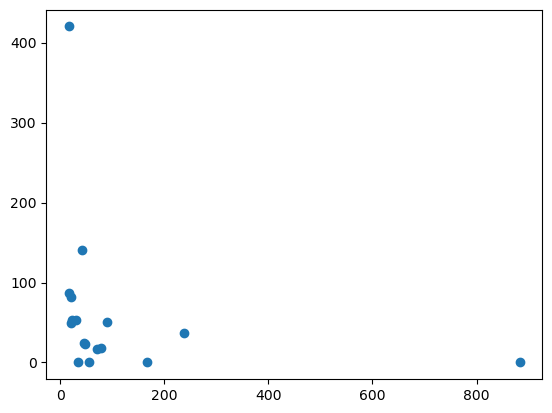

In [15]:
import matplotlib.pyplot as plt
plt.scatter(catalog_all['mass'], catalog_all['spec_virial_hnco'])

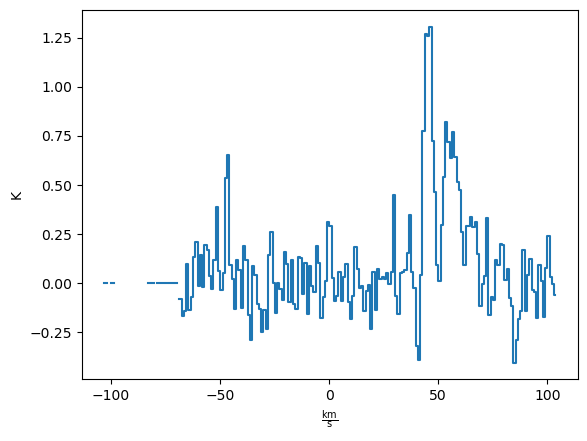

In [10]:
# average_spectra_hnco[list(average_spectra_hnco.keys())[0]].quicklook()